# Part 2 (ViT Model)

In [14]:
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import tarfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import pathlib
from keras.models import load_model
import shutil
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Conv2D,Activation,MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
import seaborn as sns
from keras import backend as K
from keras.models import Model
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from matplotlib import cm
from sklearn.metrics import confusion_matrix,f1_score

In [15]:
print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



# Import Data

In [3]:
################################# 
#untar files and save in ./Images
#################################

# file_count = 3 # only first three 

# for i in range(file_count):
#     file = tarfile.open('images_00'+i+'.tar.gz')
#     file.extractall('./Images')
#     file.close()

In [16]:
# list of train and val images
train_val_idx = pd.read_csv('train_val_list.txt', header = None)
display(train_val_idx.head())
len(train_val_idx)

,0
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png


86524

In [17]:
# list of test images
test_idx = pd.read_csv('test_list.txt', header = None)
display(test_idx.head())
len(test_idx)

,0
0,00000003_000.png
1,00000003_001.png
2,00000003_002.png
3,00000003_003.png
4,00000003_004.png


25596

In [18]:
# main dataframe
df = pd.read_csv("Data_Entry_2017_v2020.csv")
df_binary = df.copy()

In [7]:
##Code to revert Sick and NotSick to one Images folder

# source1 = "./Images/sick"
# dest = "./Images"
# source2 = "./Images/notsick"
# files = os.listdir(source1)
# # os.mkdir(dest1)
# # os.mkdir(dest2)}

# for f in files:
#     shutil.move(source1 + '/'+ f, dest + '/'+ f)
    
# files = os.listdir(source2)    
# for f in files:
#     shutil.move(source2 + '/'+ f, dest + '/'+ f)    


In [19]:
# delete folder sick
dir_path = "./Images/sick"

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: ./Images/sick : No such file or directory


In [20]:
# delete folder not sick
dir_path = "./Images/notsick"

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: ./Images/notsick : No such file or directory


# Pre-Processing

In [21]:
#OneHot Encode Labels
mlb = MultiLabelBinarizer()
df_binary['test']=df_binary['Finding Labels'].str.split("|")
df_processed = pd.concat([df_binary,pd.DataFrame(mlb.fit_transform(df_binary['test']),columns=mlb.classes_, index=df_binary.index)],axis=1)

In [22]:
df_processed.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


In [23]:
# obtain df_train from df_processed
df_train = df_processed.loc[df_processed['Image Index'].isin(train_val_idx[0].values)]
df_train = df_train.drop(['Finding Labels', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'test', 'No Finding'], axis = 1)
df_train.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,00000004_000.png,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [24]:
# obtain df_test from df_processed
df_test = df_processed.loc[df_processed['Image Index'].isin(test_idx[0].values)]
df_test = df_test.drop(['Finding Labels', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'test', 'No Finding'], axis = 1)
df_test.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4,00000003_001.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00000003_002.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,00000003_003.png,3,0,0,0,0,0,0,0,1,1,0,0,0,0,0
7,00000003_004.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,00000003_005.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
# split df_train into train and val (data leakage does not matter here)
df_train, df_val = train_test_split(df_train, test_size=0.2)

In [26]:
# Check for data leakage
train_patients = set(df_train['Patient ID'].values)
test_patients = set(df_test['Patient ID'].values)
patients_in_both_groups = train_patients.intersection(test_patients)
len(patients_in_both_groups)

0

In [27]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [28]:
# how many total images we are using for train, val, test
print(f"{len([name for name in os.listdir('./Images/')])} images are in the Images/ folder")

35000 images are in the Images/ folder


In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, target_w, target_h, shuffle=True, batch_size=8, seed=1):

    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        height_shift_range= 0.05, 
        width_shift_range=0.05, 
        rotation_range=5, 
        shear_range = 0.05,
        zoom_range=0.15)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [19]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, target_w, target_h, sample_size=100, batch_size=8, seed=1):

    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image Index", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [20]:
## create data generators
# set target dimensions
W = 128
H = 128
IMAGE_DIR = "./Images/"
train_generator = get_train_generator(df_train, IMAGE_DIR, "Image Index", labels, W, H)
valid_generator, test_generator= get_test_and_valid_generator(df_val, df_test, df_train, IMAGE_DIR, "Image Index", labels, W, H)

getting train generator...


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 45698 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 23521 validated image filenames.
getting train and valid generators...


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 45698 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 23521 validated image filenames.


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 11432 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Found 5873 validated image filenames.
Found 5605 validated image filenames.


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 19991 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


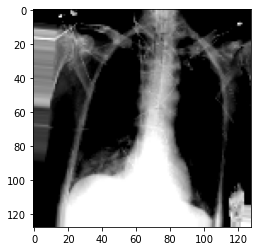

In [21]:
# visualize example
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

# Data Exploration and Class Imbalance

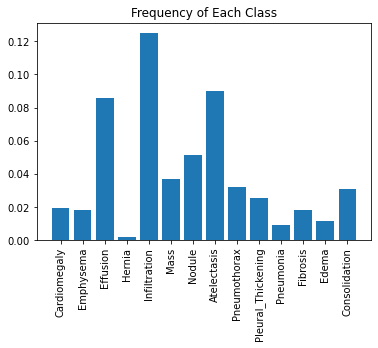

In [22]:
# check for class imbalance
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [23]:
freq_pos = np.sum(train_generator.labels, axis=0) / train_generator.labels.shape[0]
freq_neg = np.sum(train_generator.labels == 0, axis=0) / train_generator.labels.shape[0]

In [24]:
pos_weights = freq_neg
neg_weights = freq_pos

In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -1 * K.mean((tf.cast(pos_weights[i], tf.float32) * tf.cast(y_true[:, i], tf.float32) * tf.cast(K.log(tf.cast(y_pred[:, i], tf.float32)),tf.float32) + epsilon) + 
                     tf.cast(neg_weights[i], tf.float32) * (1 - tf.cast(y_true[:, i], tf.float32)) * tf.cast(K.log(1 - tf.cast(y_pred[:, i], tf.float32) + epsilon),tf.float32))
        return loss
        
    return weighted_loss

# Modeling

## Vision Transformer

Here, play with the multi-head attention transformer architecture from NLP and try to apply it to images instead of using a convolutional neural network. 

In [70]:
#Inspired from https://www.kaggle.com/code/raufmomin/vision-transformer-vit-fine-tuning/notebook

In [26]:
!pip install --quiet vit-keras

from vit_keras import vit, utils, visualize
import tensorflow_addons as tfa

In [27]:
vit_model = vit.vit_b16(
        image_size = 128,
        activation = 'sigmoid',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 14)

/home/u_81532737/.local/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


In [28]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 8, 8, 768)         590592    
                                                                 
 reshape (Reshape)           (None, 64, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 65, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 65, 768)          49920     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 65, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [29]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Example of How Transformers Interpert Images in Patches

In [30]:
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


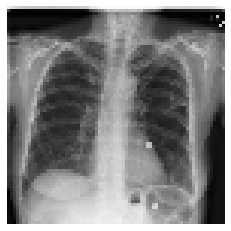

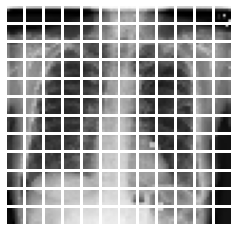

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

# image, y = train_generator.__getitem__(1)
image = utils.read('Images/00000005_007.png', image_size)
# v = image[0]
plt.imshow(image)
plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
patches = Patches(patch_size)([image])
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

### Fine Tuning Model

In [32]:
for layer in vit_model.layers[:16]:
    layer.trainable = False

In [33]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(14, 'sigmoid')
    ],
    name = 'vision_transformer')

# model.summary()

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks_list = [early_stopping]

learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=get_weighted_loss(pos_weights, neg_weights))
steps_per_epoch = len(train_generator) 
validation_steps = len(valid_generator) 

history1 = model.fit(x = train_generator,
          steps_per_epoch = steps_per_epoch,
          validation_data = valid_generator,
          validation_steps = validation_steps,
          epochs = 8,
          callbacks = callbacks_list)

Epoch 1/8


2022-05-06 15:23:08.753303: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-06 15:24:07.228196: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2941/2941 [==============================] - 875s 251ms/step - loss: 0.7652 - val_loss: 0.7147
Epoch 2/8
2941/2941 [==============================] - 620s 211ms/step - loss: 0.7054 - val_loss: 0.6930
Epoch 3/8
2941/2941 [==============================] - 569s 193ms/step - loss: 0.6828 - val_loss: 0.6564
Epoch 4/8
2941/2941 [==============================] - 570s 194ms/step - loss: 0.6710 - val_loss: 0.6545
Epoch 5/8
2941/2941 [==============================] - 581s 197ms/step - loss: 0.6631 - val_loss: 0.6456
Epoch 6/8
2941/2941 [==============================] - 576s 196ms/step - loss: 0.6585 - val_loss: 0.6376
Epoch 7/8
2941/2941 [==============================] - 568s 193ms/step - loss: 0.6555 - val_loss: 0.6472
Epoch 8/8
2941/2941 [==============================] - 571s 194ms/step - loss: 0.6538 - val_loss: 0.6334


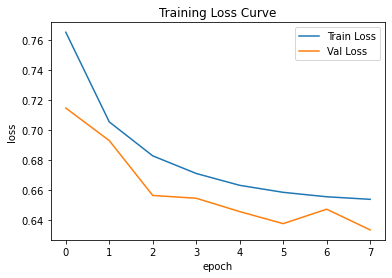

In [73]:
plt.plot(history1.history['loss'],label="Train Loss")
plt.plot(history1.history['val_loss'],label="Val Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

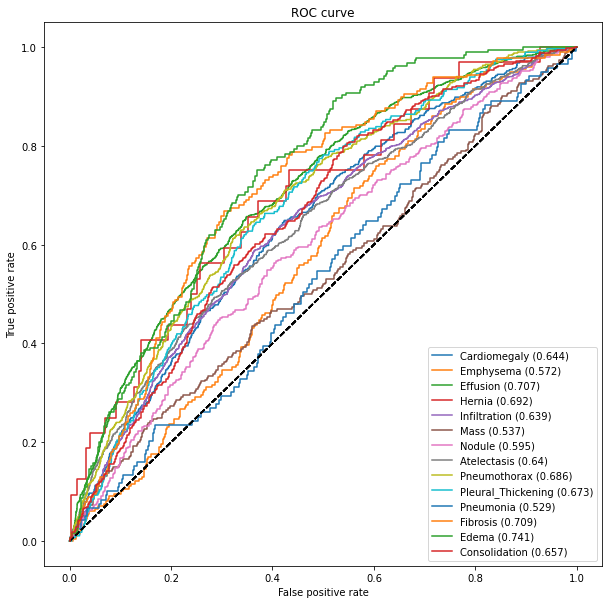

In [43]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
auc_roc_vals = []
for i in range(len(labels)):
    gt = test_generator.labels[:, i]
    pred = predicted_vals[:, i]
    auc_roc = roc_auc_score(gt, pred)
    auc_roc_vals.append(auc_roc)
    fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
    plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.show()

In [86]:
df_train.loc[df_train['Image Index'] == '00000005_007.png']

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20,00000005_007.png,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0


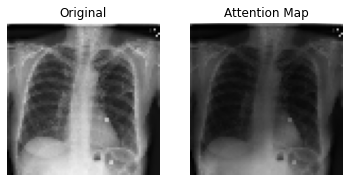

In [87]:
image = utils.read('Images/00000005_007.png', image_size)
attention_map = visualize.attention_map(model=vit_model, image=image)
# print('Prediction:', classes[
#     model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
# )  # Prediction: Eskimo dog, husky

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [102]:
model.save_weights("VIT_Xray.hdfs")